# importing necessary libraries

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import SeparableConv2D,Dense,BatchNormalization,MaxPool2D,Flatten,Dropout,Activation
from keras import backend as k
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Building train and test dataset

In [6]:
%run build_dataset.py

In [7]:
X_test = test_images

# the train data will be split into 80% train and 20% validation data
X_train,X_val,y_train,y_val = train_test_split(training_images,labels,test_size=0.2,shuffle=True)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(31367, 30, 30, 3)
(7842, 30, 30, 3)
(12630, 30, 30, 3)


In [8]:
num_classes = 43
y_train = to_categorical(y_train,num_classes = num_classes)
y_val = to_categorical(y_val,num_classes=num_classes)
print(y_train.shape,type(y_train))
print(y_val.shape,type(y_val))

(31367, 43) <class 'numpy.ndarray'>
(7842, 43) <class 'numpy.ndarray'>


### Showing examples of the dataset

(81, 30, 30, 3)


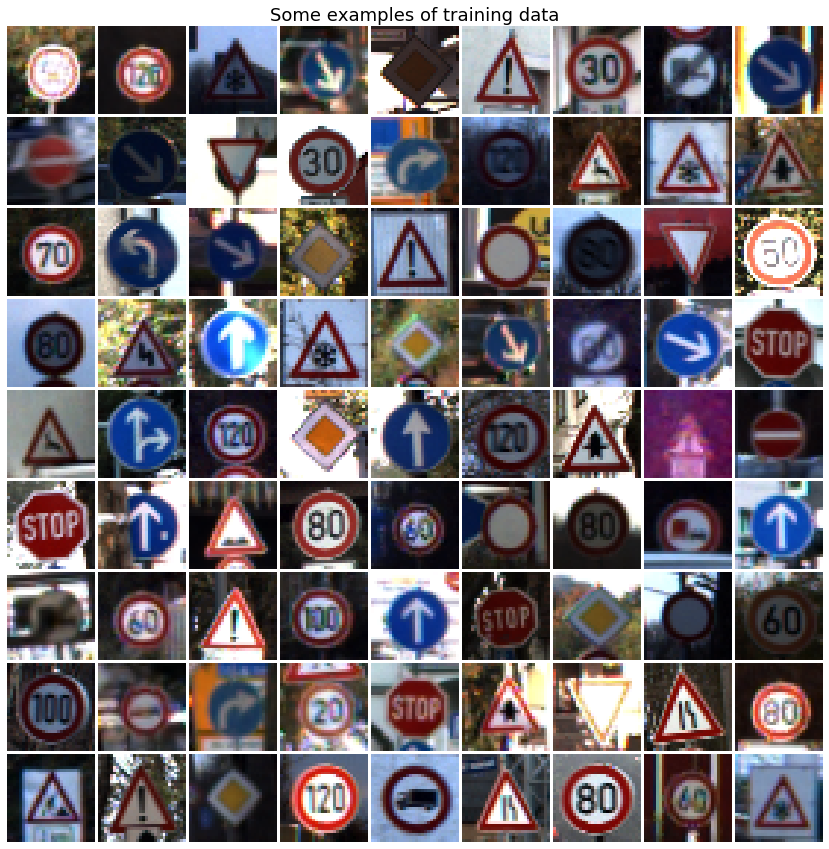

In [9]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = X_train[:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting some examples
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='gray')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Some examples of training data', fontsize=18)

# Showing the plot
plt.show()

In [10]:
# build a neural network class
class SignNet:
    @staticmethod
    def build(width,height,depth,classes):
        model = Sequential()
        input_shape = (height,width,depth)
        channel_dim = -1

        if k.image_data_format()=="channels_first": # in case the format of the image is reversed
            input_shape=(depth,height,width)
            channel_dim = 1
            
        model.add(SeparableConv2D(32,(3,3),input_shape = input_shape,padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = channel_dim))
        model.add(SeparableConv2D(32,(3,3),padding = "same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = channel_dim))
        model.add(MaxPool2D((2,2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis = channel_dim))
        model.add(Dropout(0.5))

        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        return model

In [11]:
# Defining basic parameters and optimizer for our model
num_epochs = 40
lr = 1e-3
bs = 32
model=SignNet.build(30,30,3,num_classes)
opt = Adam(learning_rate=lr,decay=lr/bs)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 30, 30, 32)        155       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 30, 30, 32)        1344      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0

In [84]:
# Fit model to the data
history = model.fit(X_train,y_train,batch_size=bs,epochs=num_epochs,validation_data=(X_val,y_val))

Epoch 1/40
981/981 [==============================] - 26s 27ms/step - loss: 0.8955 - accuracy: 0.7677 - val_loss: 0.1501 - val_accuracy: 0.9631
Epoch 2/40
981/981 [==============================] - 26s 27ms/step - loss: 0.2036 - accuracy: 0.9440 - val_loss: 0.0717 - val_accuracy: 0.9813
Epoch 3/40
981/981 [==============================] - 25s 25ms/step - loss: 0.1194 - accuracy: 0.9662 - val_loss: 0.0499 - val_accuracy: 0.9875
Epoch 4/40
981/981 [==============================] - 25s 25ms/step - loss: 0.0897 - accuracy: 0.9749 - val_loss: 0.0366 - val_accuracy: 0.9918
Epoch 5/40
981/981 [==============================] - 25s 25ms/step - loss: 0.0682 - accuracy: 0.9792 - val_loss: 0.0405 - val_accuracy: 0.9908
Epoch 6/40
981/981 [==============================] - 26s 26ms/step - loss: 0.0561 - accuracy: 0.9827 - val_loss: 0.0277 - val_accuracy: 0.9936
Epoch 7/40
981/981 [==============================] - 26s 26ms/step - loss: 0.0509 - accuracy: 0.9846 - val_loss: 0.0290 - val_accuracy:

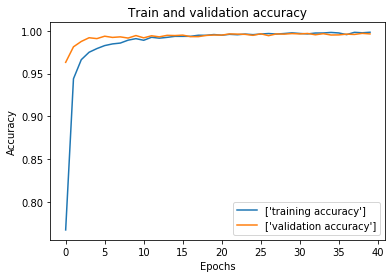

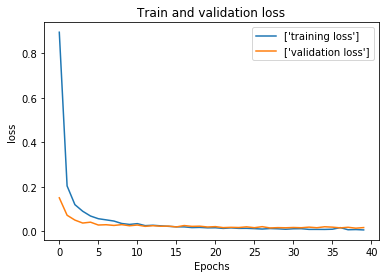

In [85]:
# plot the training and validation accuracy and loss to see if the model is overfitting or not
plt.figure(0)
plt.plot(history.history['accuracy'],label=['training accuracy'])
plt.plot(history.history['val_accuracy'],label=['validation accuracy'])
plt.title('Train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'],label=['training loss'])
plt.plot(history.history['val_loss'],label=['validation loss'])
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [13]:
# decreasing the number of epochs based on the accuracy results from previous run
num_epochs = 12
model=SignNet.build(30,30,3,num_classes)
opt = Adam(learning_rate=lr,decay=lr/bs)
# earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 3, verbose = 1,restore_best_weights = True)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics = ['accuracy'])
history = model.fit(X_train,y_train,batch_size=bs,epochs=num_epochs,validation_data=(X_val,y_val))

Epoch 1/12
981/981 [==============================] - 30s 30ms/step - loss: 0.8540 - accuracy: 0.7790 - val_loss: 0.1487 - val_accuracy: 0.9667
Epoch 2/12
981/981 [==============================] - 29s 29ms/step - loss: 0.1805 - accuracy: 0.9528 - val_loss: 0.0863 - val_accuracy: 0.9804
Epoch 3/12
981/981 [==============================] - 28s 29ms/step - loss: 0.1046 - accuracy: 0.9717 - val_loss: 0.0500 - val_accuracy: 0.9871
Epoch 4/12
981/981 [==============================] - 29s 29ms/step - loss: 0.0803 - accuracy: 0.9762 - val_loss: 0.0432 - val_accuracy: 0.9884
Epoch 5/12
981/981 [==============================] - 29s 30ms/step - loss: 0.0660 - accuracy: 0.9807 - val_loss: 0.0366 - val_accuracy: 0.9899
Epoch 6/12
981/981 [==============================] - 29s 29ms/step - loss: 0.0529 - accuracy: 0.9830 - val_loss: 0.0446 - val_accuracy: 0.9867
Epoch 7/12
981/981 [==============================] - 29s 29ms/step - loss: 0.0478 - accuracy: 0.9846 - val_loss: 0.0338 - val_accuracy:

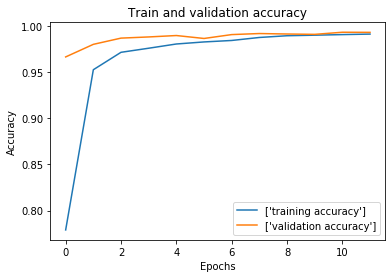

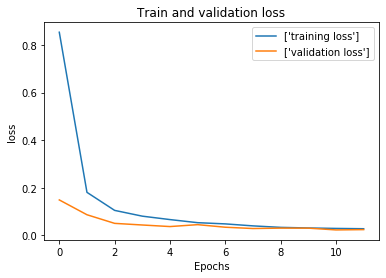

In [14]:
plt.figure(0)
plt.plot(history.history['accuracy'],label=['training accuracy'])
plt.plot(history.history['val_accuracy'],label=['validation accuracy'])
plt.title('Train and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'],label=['training loss'])
plt.plot(history.history['val_loss'],label=['validation loss'])
plt.title('Train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

(12630, 30, 30, 3)
(12630,)


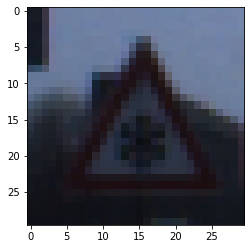

In [15]:
X_test=test_images
y_test = test_table['ClassId'].values
print(X_test.shape)
print(y_test.shape)
plt.imshow(X_train[2])

In [16]:
y_pred=model.predict_classes(X_test,verbose = 1)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
395/395 [==============================] - 2s 5ms/step


In [17]:
print(y_pred.shape)
print(y_test.shape)
print(classification_report(y_test,y_pred))

(12630,)
(12630,)
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        60
           1       0.99      0.94      0.97       720
           2       0.92      0.99      0.96       750
           3       0.93      0.95      0.94       450
           4       0.97      0.95      0.96       660
           5       0.90      0.97      0.93       630
           6       0.98      0.83      0.90       150
           7       0.92      0.94      0.93       450
           8       0.95      0.89      0.92       450
           9       0.98      0.99      0.98       480
          10       0.97      0.99      0.98       660
          11       0.97      0.93      0.95       420
          12       0.99      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       0.99      0.99      0.99       270
          15       0.99      1.00      0.99       210
          16       1.00      0.98      0.99       150
         